I used the example code provided in this assignment

Step 1. Import the required modules and obtain the backend

In [ ]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import math

provider = QuantumRingsProvider(
    token='',
    name=''
)
backend = provider.get_backend("scarlet_quantum_rings")
shots = 1024

provider.active_account()

Step 2. Define the core methods

In [7]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

Step 3. Perform the algorithm

Let's try to write Shor's algorithm for factoring the number 6. I'm doing this to try to build a general algorithm for factoring a number

$2^x \space mod \space 6$

In [8]:
# Shor’s algorithm to factorize 6 using 2^x mod 6.
numberofqubits = 7
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(4 , 'c')
qc = QuantumCircuit(q, c)

# Initialize source and target registers

qc.h(0)
qc.h(1)
qc.h(2)
qc.x(6)
qc.barrier()

# Modular exponentiation 2^x mod 6

qc.cx(q[2],q[5])
qc.ccx(q[1], q[6], q[4])
qc.cx(q[2], q[6])
qc.ccx(q[1], q[2], q[4])
qc.ccx(q[1], q[4], q[6])

qc.barrier()

# IQFT. Refer to implementation from earlier examples
iqft_cct (qc, q, 3)

# Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

# Draw the circuit
qc.draw('mpl')

       ┌───┐ ╎                           ╎ ┌───┐                                   »
q[0]: ■┤ H ├─╎───────────────────────────╎─┤ H ├───────■───────────────────■───────»
       ├───┤ ╎                           ╎ └───┘┌──────┴──────┐┌───┐       │       »
q[1]: ■┤ H ├─╎────────■─────────■────■───╎──────┤ U1(-pi/2)   ├┤ H ├───────│───────»
       ├───┤ ╎        │         │    │   ╎      └─────────────┘└───┘┌──────┴──────┐»
q[2]: ■┤ H ├─╎───■────│────■────■────│───╎──────────────────────────┤ U1(-pi/4)   ├»
       └───┘ ╎   │    │    │    │    │   ╎                          └─────────────┘»
q[3]: ■──────╎───│────│────│────│────│───╎─────────────────────────────────────────»
             ╎   │  ┌─┴─┐  │  ┌─┴─┐  │   ╎                                         »
q[4]: ■──────╎───│──┤ X ├──│──┤ X ├──■───╎─────────────────────────────────────────»
             ╎ ┌─┴─┐└─┬─┘  │  └───┘  │   ╎                                         »
q[5]: ■──────╎─┤ X ├──│────│─────────│───╎───────────────────────

The circuit to factor 6 shown above.

Job Running
Job Done.
Ending Job Monitor


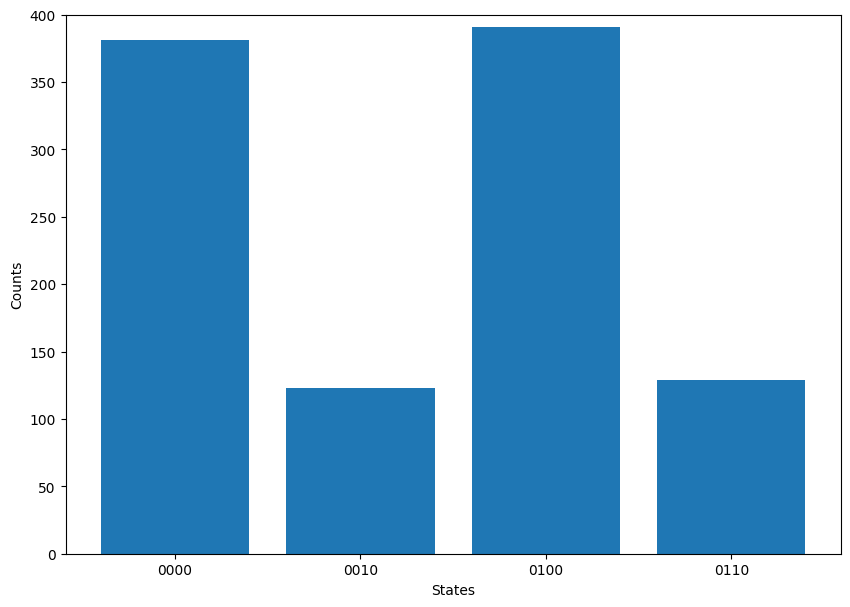

In [9]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

# visualize
plot_histogram(counts)

#clean up
del q, c, qc
del result
del job

How can we see period 2. Since we have two frequently observed states. The other two states that we can see on the histogram are most likely errors caused by noise.

Hence the first factor is 3, and the second will be 2.

$lcm((p-1), (q-1))=2 \Rightarrow q=3 \Rightarrow p=\frac{6}{3}=2$


Now let's try for 10

$2^x \space mod \space 10$

In [10]:
# Shor’s algorithm to factorize 15 using 2^x mod 10.
numberofqubits = 7
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(4 , 'c')
qc = QuantumCircuit(q, c)

# Initialize source and target registers

qc.h(0)
qc.h(1)
qc.h(2)
qc.x(6)
qc.barrier()

# Modular exponentiation 2^x mod 10

qc.cx(q[2],q[5])
qc.ccx(q[1], q[6], q[4])
qc.cx(q[2], q[6])
qc.ccx(q[1], q[2], q[4])
qc.ccx(q[1], q[4], q[6])
qc.barrier()
qc.ccx(q[1], q[2], q[3])
qc.ccx(q[2], q[3], q[5])
qc.cx(q[6], q[5])
qc.cx(q[6], q[4])
qc.ccx(q[4], q[5], q[6])

qc.barrier()

# IQFT. Refer to implementation from earlier examples
iqft_cct (qc, q, 3)

# Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

# Draw the circuit
qc.draw('mpl')

       ┌───┐ ╎                           ╎                           ╎ »
q[0]: ■┤ H ├─╎───────────────────────────╎───────────────────────────╎─»
       ├───┤ ╎                           ╎                           ╎ »
q[1]: ■┤ H ├─╎────────■─────────■────■───╎───■───────────────────────╎─»
       ├───┤ ╎        │         │    │   ╎   │                       ╎ »
q[2]: ■┤ H ├─╎───■────│────■────■────│───╎───■────■──────────────────╎─»
       └───┘ ╎   │    │    │    │    │   ╎ ┌─┴─┐  │                  ╎ »
q[3]: ■──────╎───│────│────│────│────│───╎─┤ X ├──■──────────────────╎─»
             ╎   │  ┌─┴─┐  │  ┌─┴─┐  │   ╎ └───┘  │       ┌───┐      ╎ »
q[4]: ■──────╎───│──┤ X ├──│──┤ X ├──■───╎────────│───────┤ X ├──■───╎─»
             ╎ ┌─┴─┐└─┬─┘  │  └───┘  │   ╎      ┌─┴─┐┌───┐└─┬─┘  │   ╎ »
q[5]: ■──────╎─┤ X ├──│────│─────────│───╎──────┤ X ├┤ X ├──│────■───╎─»
       ┌───┐ ╎ └───┘  │  ┌─┴─┐     ┌─┴─┐ ╎      └───┘└─┬─┘  │  ┌─┴─┐ ╎ »
q[6]: ■┤ X ├─╎────────■──┤ X ├─────┤ X ├─╎─────────

Job Queued
Job Done.
Ending Job Monitor


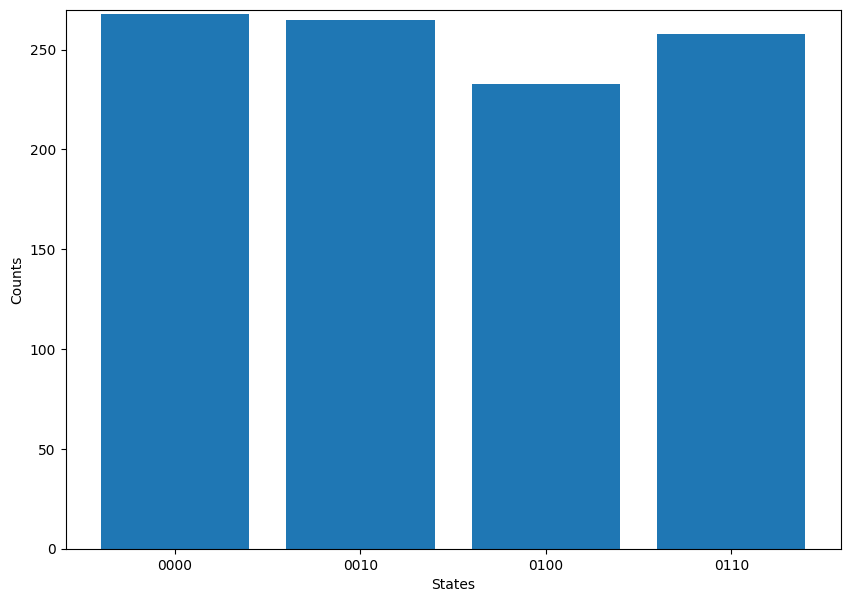

In [11]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

# visualize
plot_histogram(counts)

#clean up
del q, c, qc
del result
del job

How can we see period 4.

Then one of the factors of 5

$lcm((p-1), (q-1)) = 4 \Rightarrow q=5 \Rightarrow p=\frac{10}{5} = 2$

As we can see, for 10 a pair of quantum gates were added to the existing scheme for 6.
Namely these gates

```python
qc.ccx(q[1], q[2], q[3])
qc.ccx(q[2], q[3], q[5])
qc.cx(q[6], q[5])
qc.cx(q[6], q[4])
qc.ccx(q[4], q[5], q[6]
```

I started trying to generalize the algorithm for constructing a quantum circuit for the expression $2^x \space mod \space b$, but unfortunately, I didn't have enough time to form a generalization of the algorithm for constructing a quantum circuit.

Footnotes

[1] This section is based on [10], [14], and [16].

[2] https://research.ibm.com/blog/factor-15-shors-algorithm

[3] https://en.wikipedia.org/wiki/Integer_factorization_records#Records_for_efforts_by_quantum_computers